In [4]:
from Pipelines.process import *
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, GAM, s, f, te, l
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import math
import numpy as np

In [5]:
df_1 = pd.read_csv("../train_01.csv")

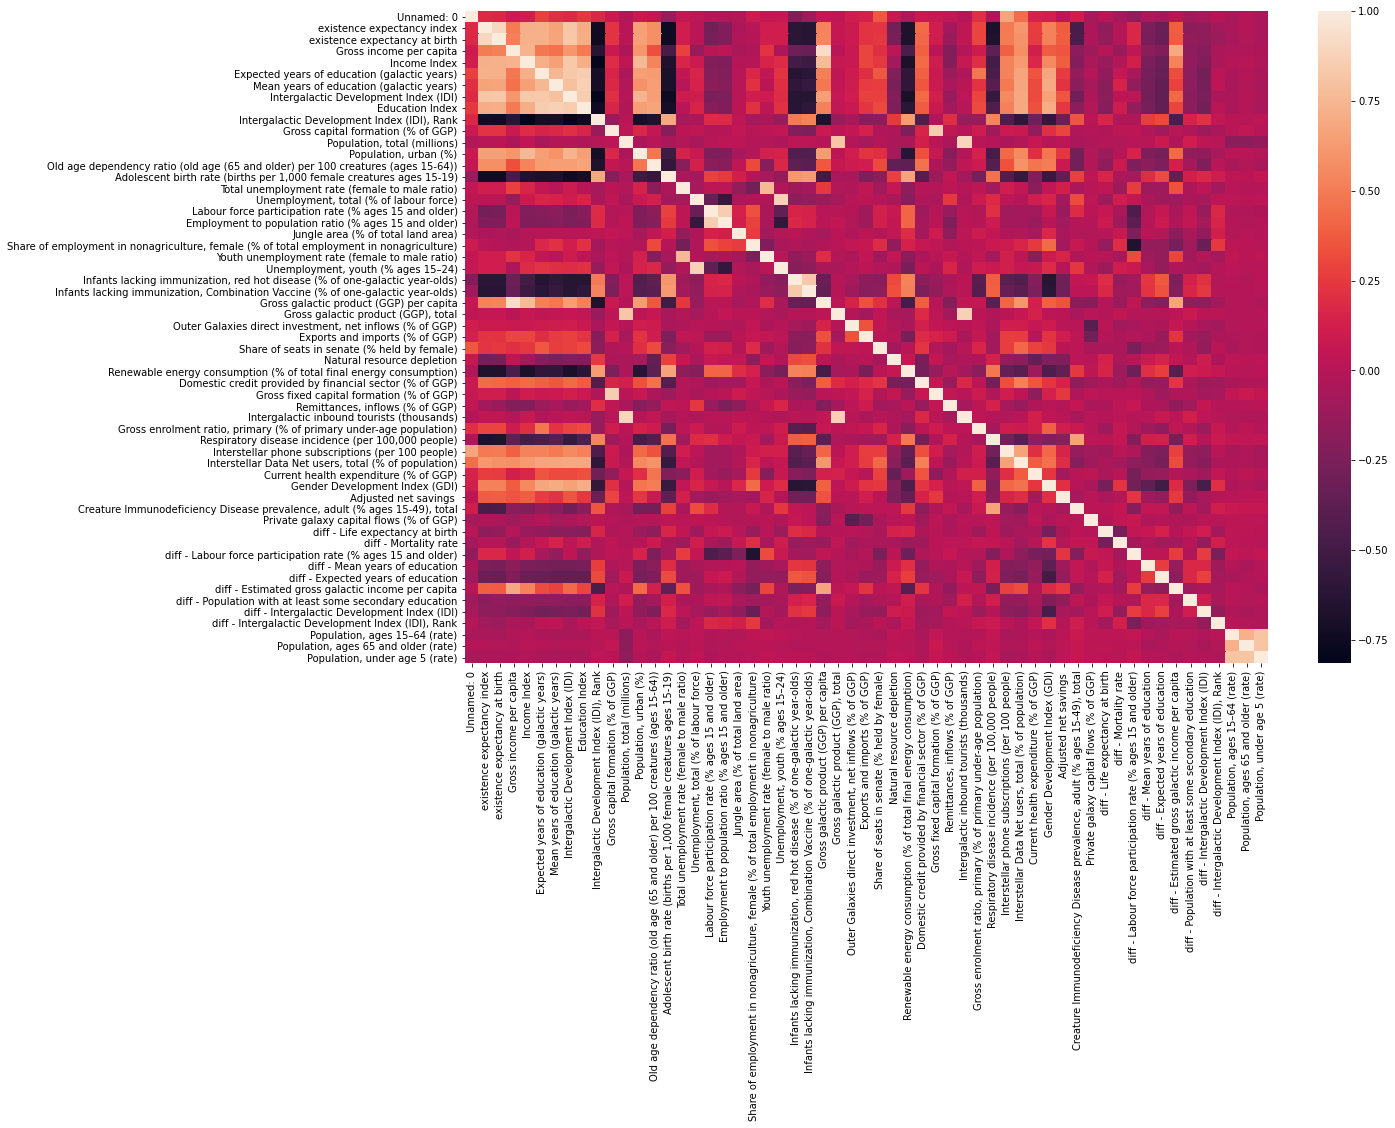

In [8]:
corr = df_1.loc[:, (df_1.columns != 'galactic year') & (df_1.columns != 'galaxy') & (df_1.columns != 'y')].corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr)
plt.show()

In [67]:
ser.index

Index(['galaxy', 'galactic year', 'y', 'existence expectancy index',
       'existence expectancy at birth', 'Population, urban (%)',
       'Unemployment, youth (% ages 15–24)',
       'Unemployment, total (% of labour force)',
       'Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Renewable energy consumption (% of total final energy consumption)',
       'Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)',
       'Gross galactic product (GGP) per capita', 'Income Index',
       'Gross income per capita',
       'Infants lacking immunization, red hot disease (% of one-galactic year-olds)',
       'Respiratory disease incidence (per 100,000 people)',
       'Domestic credit provided by financial sector (% of GGP)',
       'Interstellar Data Net users, total (% of population)',
       'Natural resource depletion', 'Adjusted net savings

In [6]:
features = ['galaxy', 'galactic year', 'existence expectancy index',
       'existence expectancy at birth', 'Population, urban (%)',
       'Unemployment, youth (% ages 15–24)',
       'Unemployment, total (% of labour force)',
       'Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Renewable energy consumption (% of total final energy consumption)',
       'Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)',
       'Gross galactic product (GGP) per capita', 'Income Index',
       'Gross income per capita',
       'Infants lacking immunization, red hot disease (% of one-galactic year-olds)',
       'Respiratory disease incidence (per 100,000 people)',
       'Domestic credit provided by financial sector (% of GGP)',
       'Interstellar Data Net users, total (% of population)',
       'Natural resource depletion', 'Adjusted net savings ',
       'Gross capital formation (% of GGP)',
       'Intergalactic Development Index (IDI), Rank',
       'Mean years of education (galactic years)',
       'Expected years of education (galactic years)',
       'Gender Development Index (GDI)']



targets = [ 
       'Population, under age 5 (rate)',
       'Population, ages 65 and older (rate)', 
       'diff - Labour force participation rate (% ages 15 and older)', # >10%, H20GBM
       'Labour force participation rate (% ages 15 and older)',# >20%, H20GBM
       'Employment to population ratio (% ages 15 and older)',# >20% H20GBM
       'Share of employment in nonagriculture, female (% of total employment in nonagriculture)',#10%, H20GBM
       'Gross fixed capital formation (% of GGP)' #>20%, H20RF
       'Interstellar phone subscriptions (per 100 people)', #>10% H2oGB
       'Private galaxy capital flows (% of GGP)', #>10% H2oGB
       'Current health expenditure (% of GGP)', #>10% H2oGB
       ]

RF_targets = ['Remittances, inflows (% of GGP)','Youth unemployment rate (female to male ratio)']



In [71]:
from pygam import LinearGAM, GAM, s, f, te, l
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV

In [72]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [76]:
h2o.shutdown()

/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_a4af closed.


In [77]:
df_predicted = df_1.copy()
RMSE_list = []
h2o.init()
h2o.cluster().show_status()

for TARGET in targets:

    df_predictors = df_predicted.loc[:,  features + [TARGET]]
    
    df_predictors = df_predictors.dropna()
    
    h2o_df = h2o.H2OFrame(df_predictors)

    train, test = h2o_df.split_frame(ratios=[.8], seed=1234)
    
    
    predictors = features
    
    response = TARGET
    
    hyper_params_tune = {
            'max_depth' : list(range(5,60,1)),
            'nbins': [2**x for x in range(4,9)],
            'nbins_cats': [2**x for x in range(4,9)],
            'ntrees': [100,200,400,800, 1000],
            'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
    
    search_criteria_tune = {'strategy': "RandomDiscrete",
                       'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                       'max_models': 100,  ## build no more than 100 models
                       'seed' : 1234,
                       'stopping_rounds' : 5,
                       'stopping_metric' : "rmse",
                       'stopping_tolerance': 1e-3
                       }
    
    rf_v1 = H2ORandomForestEstimator(model_id="rf_covType_v1")
    

    h2orf = H2OGridSearch(rf_v1, grid_id='gbm_.{0}'.format(TARGET), hyper_params=hyper_params_tune,
                           search_criteria = search_criteria_tune)

    h2orf.train(x=predictors, y=response, training_frame=train, seed=1111)
    
    
    rf_gridperf1 = h2orf.get_grid(sort_by='mse', decreasing=False)
    
    
    bestrf = rf_gridperf1.models[0]

    rmse = bestrf.model_performance(test).rmse()
    print('RMSE for {0}: {1}'.format(TARGET,rmse))
    RMSE_list.append(rmse)
    h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_251"; Java(TM) SE Runtime Environment (build 1.8.0_251-b08); Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from /Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp5jhk05ms
  JVM stdout: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp5jhk05ms/h2o_azizbenmosbah_started_from_python.out
  JVM stderr: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp5jhk05ms/h2o_azizbenmosbah_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_azizbenmosbah_z3zftw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_azizbenmosbah_z3zftw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for Population, total (millions): 279.3102164658498
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for diff - Life expectancy at birth: 4.767764146911866
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for Population, ages 15–64 (rate): 1.022957792789197
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for Population, under age 5 (rate): 0.22041148339667951
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |█████████

In [ ]:
df_predicted = df_1.copy()

h2o.init()
h2o.cluster().show_status()

for TARGET in targets:

    df_predictors = df_predicted.loc[:,  features + [TARGET]]
    
    df_predictors = df_predictors.dropna()
    
    h2o_df = h2o.H2OFrame(df_predictors)

    train, test = h2o_df.split_frame(ratios=[.8], seed=1234)
    
    
    predictors = features
    
    response = TARGET
    
    hyper_params_tune = {'max_depth' : list(range(1,21,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [1,2,4,8,16,25],
                'nbins': [2**x for x in range(4,9)],
                'nbins_cats': [2**x for x in range(4,9)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
    
    search_criteria_tune = {'strategy': "RandomDiscrete",
                       'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                       'max_models': 100,  ## build no more than 100 models
                       'seed' : 1234,
                       'stopping_rounds' : 5,
                       'stopping_metric' : "rmse",
                       'stopping_tolerance': 1e-3
                       }
    
    
  
    h2ogbm = H2OGradientBoostingEstimator(nfolds=5,
                                         learn_rate=0.05,
                                         learn_rate_annealing = 0.99,
                                         score_tree_interval = 10, 
                                         stopping_rounds = 5,
                                         stopping_metric = "rmse",
                                         stopping_tolerance = 1e-4,
                                         ntrees= 1000,
                                         seed=1111,
                                         keep_cross_validation_predictions = True,
                                         distribution ='gaussian')
    

    

    h2ogbm = H2OGridSearch(h2ogbm, grid_id='gbm_.{0}'.format(TARGET), hyper_params=hyper_params_tune,
                           search_criteria = search_criteria_tune)

    h2ogbm.train(x=predictors, y=response, training_frame=train, seed=1111)
    
    
    gbm_gridperf1 = h2ogbm.get_grid(sort_by='mse', decreasing=False)
    
    
    bestgbm = gbm_gridperf1.models[0]

    rmse = bestgbm.model_performance(test).rmse()
    print('RMSE for {0}: {1}'.format(TARGET,rmse))
    #RMSE_list.append(rmse)
    h2o.remove_all()


In [12]:
df_reg_2 = df_1.copy()
df_predicted = df_1.copy()
RMSE_list = []
i=0
for TARGET in RF_targets:

    df_predictors = df_predicted.loc[:, features + [TARGET]]
    
    df_predictors = df_predictors.dropna()
    df_predictors = pd.get_dummies(df_predictors)
    df_predictors = df_predictors.dropna()
    X_train, X_test, y_train, y_test = train_test_split(df_predictors.loc[:, ((df_predictors.columns != TARGET) & (df_predictors.columns != 'galaxy'))], df_predictors[TARGET], test_size=0.33, random_state=42)
    
    if (i == 0):
        param_grid = {#'bootstrap': [True, False],
                     'max_depth': [25, 30, 35],
                     'max_features': ['sqrt'],
                     #'min_samples_leaf': [1, 2, 4],
                     #'min_samples_split': [2, 5, 10],
                     'n_estimators': [800,1000,1200]}
    else:
        param_grid = {#'bootstrap': [True, False],
                     'max_depth': [40,50,60,79],
                     'max_features': ['sqrt'],
                     #'min_samples_leaf': [1, 2, 4],
                     #'min_samples_split': [2, 5, 10],
                     'n_estimators': [800]}
    
    regr = RandomForestRegressor(random_state=0)
    
    
    clf = GridSearchCV(regr, param_grid)
    clf.fit(X_train, y_train)
    
    
    print(clf.best_params_)
    print('RMSE for {0}: {1}'.format(TARGET,sqrt(mean_squared_error(y_test, clf.predict(X_test)))))
    RMSE_list.append(sqrt(mean_squared_error(y_test, clf.predict(X_test))))
    i = i+1

#RMSE_df['Default_RF'] = RMSE_list

{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 800}
RMSE for Remittances, inflows (% of GGP): 5.187564605746734
{'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 800}
RMSE for Youth unemployment rate (female to male ratio): 0.487998649441446
